In [6]:
# from sumSignalDroso import sumSignal1_par
# from localOptimize import optimize_local1_par
# from gaForDeconvolution import optimize_ga1_par
from setParameters import *

import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.io import savemat
from scipy.io import loadmat
import timeit
import numpy as np
import os
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/home/rachel/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [9]:
# Define the parameters

# ---------------- Save these parameters -----------------#
parameterFile = '1.5eefParameters'
setParameters(parameterFile)

67
700
5800
8300
30
1.5


AttributeError: 'setParameters' object has no attribute 'param'

In [16]:
from readArtificialData import *

DataFilePath = './demo_data/'
outputFolder = DataFilePath
readArtificialData(DataFilePath, outputFolder)

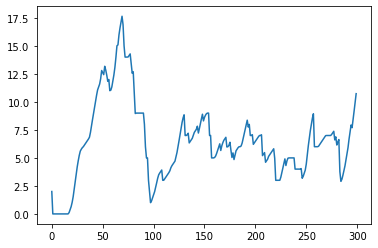

In [4]:
#Look at individual traces
DataFilePath = './demo_data/'
for DataFileName in os.listdir(DataFilePath):
    if DataFileName.endswith(".npz"):
        matcontent=np.load(DataFilePath+DataFileName)

DataExp=matcontent['DataExp']

cellNo=0
plt.plot(DataExp[:,cellNo])


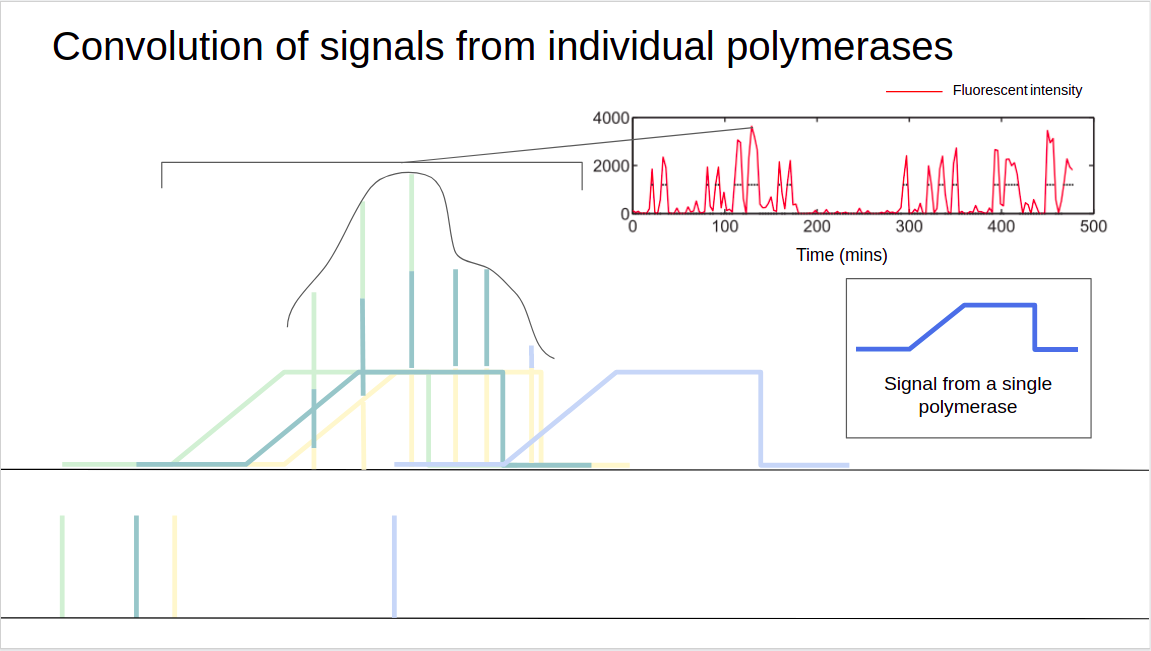

In [7]:
from IPython.display import Image
Image(filename='./polSignal.png', width=700)

In [8]:
#-------------------- Setting up the deconvolution problem ---------------------------#

frame_num=len(DataExp) ### number of frames
print("\nNumber of frames or time points: {}".format(frame_num))
DureeSimu = frame_num*params.FrameLen  ### film duration in s
print("\nFilm duration in secs (DureeSimu): {}\n or in mins : {:2.4}".format(DureeSimu, DureeSimu/60))
print("\nSignal duration in secs (DureeSignal): {} \nCalculated as \"TaillePreMarq + TailleSeqMarq + TaillePostMarq) / Polym_speed\"".format(params.DureeSignal))
DureeAnalysee = params.DureeSignal + DureeSimu ###(s)
print("\nDuration of analysis in secs : (Duration of film + Duration of one signal) {:.6}".format(DureeAnalysee))
num_possible_poly = round(DureeAnalysee/(params.EspaceInterPolyMin/params.Polym_speed)) # maximal number of polymerase positions
print("\nTotal number of polymerase positions :{}\n# maximal number of polymerase positions".format(num_possible_poly))
sd=DataExp.shape
print("\nShape of the trace matrix : (time frames, number of cells){}".format(sd))

# Getting possible positions of the polymerases 

nloops = len(DataExp[0])
PosPred=np.zeros((num_possible_poly,nloops)) # np.zeros(num_possible_poly,(len(DataExp[0]))) # short for positions predictions
print("PosPred\nShape of matrix for prediction of polymerase positions {}\nContains the indices of polymerase positions out of the 3397 possible".format(PosPred.shape))
DataPred =np.zeros((sd[0],sd[1])) #signal prediction
print("\nDataPred\nShape of matrix for signal prediction {}".format(DataPred.shape))
Fit=np.zeros((nloops))
nloops


Number of frames or time points: 300

Film duration in secs (DureeSimu): 1170.0
 or in mins : 19.5

Signal duration in secs (DureeSignal): 130.2 
Calculated as "TaillePreMarq + TailleSeqMarq + TaillePostMarq) / Polym_speed"

Duration of analysis in secs : (Duration of film + Duration of one signal) 1300.2

Total number of polymerase positions :1950
# maximal number of polymerase positions

Shape of the trace matrix : (time frames, number of cells)(300, 200)
PosPred
Shape of matrix for prediction of polymerase positions (1950, 200)
Contains the indices of polymerase positions out of the 3397 possible

DataPred
Shape of matrix for signal prediction (300, 200)


200

In [9]:
# Run the Genetic Algorithm for a single trace 

iexp = 13
DataExpSmooth=DataExp[:,iexp]
area = params.FreqEchImg/params.Polym_speed*params.Intensity_for_1_Polym*(params.TaillePostMarq+params.TailleSeqMarq/2) # signal from one polymerase per frame
print("Area:{:.4}".format(area))
Nbr_poly_estimate = min([round( sum(DataExpSmooth) / area),num_possible_poly])
print("First guess of number of polymerase {}\nCalculated as sum of the intenisties in each frame divided by the \"area\"".format(Nbr_poly_estimate))

Area:29.47
First guess of number of polymerase 81
Calculated as sum of the intenisties in each frame divided by the "area"


In [10]:
#Parameters for the Genetic Algorithm
TolFun = 1e-12
generations = 400

# -------------- Run the GA ----------------------#
GA_global = optimize_ga1_par(TolFun, DataExpSmooth,
                                 Nbr_poly_estimate,
                                 num_possible_poly,
                                 params.FreqEchSimu, 
                                 params.FreqEchImg, 
                                 params.TaillePreMarq, 
                                 params.TailleSeqMarq, 
                                 params.TaillePostMarq,
                                 params.Polym_speed, 
                                 frame_num, 
                                 params.Intensity_for_1_Polym, 
                                 generations)
x_GA_art =  GA_global[0]
print('done')
result_local = optimize_local1_par(DataExpSmooth,
                                   x_GA_art,
                                   num_possible_poly,
                                   params.FreqEchSimu, 
                                   params.FreqEchImg, 
                                   params.TaillePreMarq,
                                   params.TailleSeqMarq, 
                                   params.TaillePostMarq,  
                                   params.Polym_speed, 
                                   frame_num, 
                                   params.Intensity_for_1_Polym)

/home/rachel/Documents/benchmark/artificial_droso_data/demo/pygadForDeconvolution.py:331: UserWarning: The percentage of genes to mutate (mutation_percent_genes=0.03) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


ga stopped because the TolFun was reached at generation = 108
change = 0.0
done


### Let us have a look at the results of the Genetic Algorithm


Positions: position_fit (number of polymerases): 86
Shape:86

Min Fit: (Min_Fit) 68.084481543962

Prediction
Shape (prediction):300

Predicted positions
Shape : 1950


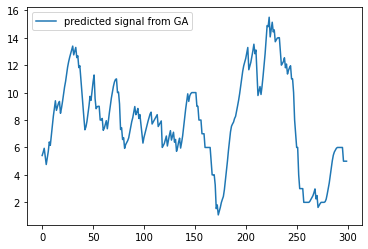

In [11]:
positions_fit = result_local[0]

print("\nPositions: position_fit (number of polymerases): {}".format(len(positions_fit)))

print("Shape:{}".format(len(positions_fit)))

Min_Fit = result_local[1]
print("\nMin Fit: (Min_Fit) {}".format(Min_Fit))

print("\nPrediction")
prediction = sumSignal1_par(positions_fit,
                            params.FreqEchSimu, 
                            params.FreqEchImg, 
                            params.TaillePreMarq,
                            params.TailleSeqMarq, 
                            params.TaillePostMarq,  
                            params.Polym_speed, 
                            frame_num, 
                            params.Intensity_for_1_Polym)
#print(prediction)
print("Shape (prediction):{}".format(len(prediction)))
plt.plot(prediction, label = "predicted signal from GA")
plt.legend()

for i in range(len(positions_fit)):
                PosPred[positions_fit[i],iexp]=1
print("\nPredicted positions")
print("Shape : {}".format(len(PosPred)))

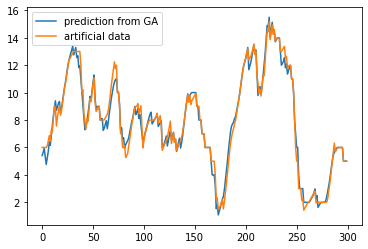

In [12]:
plt.plot(prediction, label = "prediction from GA") # -- from deconvlution
plt.plot(DataExpSmooth, label = "artificial data") # -- from artificial data
plt.legend()

In [13]:
print("Maximum number of threads available  ", mp.cpu_count())

Maximum number of threads available   12


### Now let us do the same for all traces

A set of deconvolution results have been included in the demo files in case you don't want to wait for it to run. You can have a look at the results in the following section.


In [5]:
#import function to perform deconvolution
from deconvolveMyData import *

# Provide number of threads for parallel processing
number_of_workers = 5

# Provide the path where the pre-processed data is stored
DataFilePath = './demo_data/'

# Provide the file format of the pre-processed data .npz/.mat (Takes .npz by default)
fileFormatData = '.npz'

# Let's call the function to perform deconvolution
deconvolveMyData(DataFilePath = DataFilePath, number_of_workers=number_of_workers)


data_carola_dataset5_M2_artificial_data.npz

Processing cell number 1
Processing cell number 2



/home/rachel/Documents/benchmark/artificial_droso_data/demo/pygadForDeconvolution.py:331: UserWarning: The percentage of genes to mutate (mutation_percent_genes=0.03) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))
/home/rachel/Documents/benchmark/artificial_droso_data/demo/pygadForDeconvolution.py:331: UserWarning: The percentage of genes to mutate (mutation_percent_genes=0.03) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you

ga stopped because the TolFun was reached at generation = 86
change = 0.0

Done processing cell number  2
Total time to process cell 2 is 17.629208071972243
ga stopped because the TolFun was reached at generation = 109
change = 0.0

Done processing cell number  1
Total time to process cell 1 is 21.66138018097263
pools closed
Results saved in ./demo_data/resultDec/data_carola_dataset5predictions


#### Once deconvolution has been performed, the predicted positions are saved in the same folder as the data file with the name "...predictions.npz'.

Let us load the results and look at the predictions against the experimental time traces of intensities


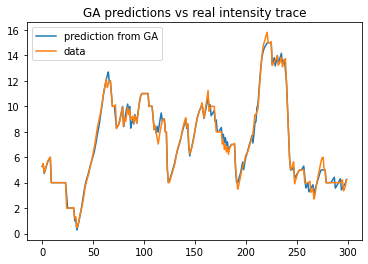

In [6]:

DataFilePath = './demo_data/resultDec/'
for DataFileName in os.listdir(DataFilePath):
    if DataFileName.endswith("predictions.npz"):
        matcontent=np.load(DataFilePath+DataFileName)

DataExp=matcontent['DataExp']
DataPred=matcontent['DataPred']

cellNo=100
plt.plot(DataPred[:,cellNo], label = "prediction from GA") # -- from deconvlution
plt.plot(DataExp[:,cellNo], label = "data") # -- from artificial data
plt.title('GA predictions vs real intensity trace') 
plt.legend()


## The above steps can be summarised as follows (Skip this if already done above)

In [ ]:
# Define the parameters

# ---------------- Save these parameters -----------------#
parameterFile = 'drosoParameters'
params = setParameters(parameterFile)

#----------------- Read data------------------------------#
DataFilePath = './demo_data/'
outputFolder = DataFilePath
readArtificialData(DataFilePath, outputFolder)

#----------------- Run deconvolution----------------------#
numberOfWorkers = 5
fileFormatData = '.npz'
deconvolveMyData(DataFilePath = DataFilePath, 
                 number_of_workers=numberOfWorkers)

## Let's find which model fits best and extract the kinetic parameters 

In [8]:
from drosoFit2 import *
pathToDeconvolutionResultsFolder='./demo_data/resultDec/'
pardor='drosoParameters.npz'
Fit2Results=fit2(pathToDeconvolutionResultsFolder,pardor)

iteration nbr  0
iteration nbr  1
iteration nbr  2
iteration nbr  3
iteration nbr  4
iteration nbr  5
iteration nbr  6
iteration nbr  7
iteration nbr  8
iteration nbr  9
iteration nbr  10
iteration nbr  11
iteration nbr  12
iteration nbr  13


/home/rachel/Documents/benchmark/artificial_droso_data/demo/drosoFit2.py:296: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(k[2]*np.exp(k[0]*xs)+(1-k[2])*np.exp(k[1]*xs) ) -np.log(1-fs)) /sN # k: parameters


iteration nbr  14
iteration nbr  15
iteration nbr  16
iteration nbr  17
iteration nbr  18
iteration nbr  19
iteration nbr  20
iteration nbr  21
iteration nbr  22
iteration nbr  23
iteration nbr  24
iteration nbr  25
iteration nbr  26
iteration nbr  27
iteration nbr  28
iteration nbr  29
iteration nbr  30
iteration nbr  31
iteration nbr  32
iteration nbr  33
iteration nbr  34
iteration nbr  35
iteration nbr  36
iteration nbr  37
iteration nbr  38
iteration nbr  39
iteration nbr  40
iteration nbr  41
iteration nbr  42
iteration nbr  43
iteration nbr  44
iteration nbr  45
iteration nbr  46
iteration nbr  47
iteration nbr  48
iteration nbr  49
iteration nbr  50
iteration nbr  51
iteration nbr  52
iteration nbr  53
iteration nbr  54
iteration nbr  55
iteration nbr  56
iteration nbr  57
iteration nbr  58
iteration nbr  59
iteration nbr  60
iteration nbr  61
iteration nbr  62
iteration nbr  63
iteration nbr  64
iteration nbr  65
iteration nbr  66
iteration nbr  67
iteration nbr  68
iteration 

In [9]:
from IPython.display import IFrame
IFrame("./python_Results2/data_carola_dataset5_result/Fit_data_carola_dataset5.pdf", width=1000, height=600)

In [10]:
from drosoFit3 import *
pathToDeconvolutionResultsFolder='./demo_data/resultDec/'
pardor='drosoParameters.npz'
Fit3Results=fit3(pathToDeconvolutionResultsFolder,pardor)

iteration nbr  0
iteration nbr  1
iteration nbr  2
iteration nbr  3
iteration nbr  4
iteration nbr  5
iteration nbr  6
iteration nbr  7


/home/rachel/Documents/benchmark/artificial_droso_data/demo/drosoFit3.py:303: RuntimeWarning: invalid value encountered in log
  return (np.log(k[3]*np.exp(k[0]*xs)+k[4]*np.exp(k[1]*xs)+(1-k[3]-k[4])*np.exp(k[2]*xs) ) -np.log(1-fs)) /sN # k: parameters


iteration nbr  8
iteration nbr  9
iteration nbr  10
iteration nbr  11
iteration nbr  12
iteration nbr  13
iteration nbr  14
iteration nbr  15
iteration nbr  16
iteration nbr  17
iteration nbr  18
iteration nbr  19
iteration nbr  20
iteration nbr  21
iteration nbr  22
iteration nbr  23
iteration nbr  24
iteration nbr  25
iteration nbr  26
iteration nbr  27
iteration nbr  28
iteration nbr  29
iteration nbr  30
iteration nbr  31
iteration nbr  32
iteration nbr  33
iteration nbr  34
iteration nbr  35
iteration nbr  36
iteration nbr  37
iteration nbr  38
iteration nbr  39
iteration nbr  40
iteration nbr  41
iteration nbr  42
iteration nbr  43
iteration nbr  44
iteration nbr  45
iteration nbr  46
iteration nbr  47
iteration nbr  48
iteration nbr  49
iteration nbr  50
iteration nbr  51
iteration nbr  52
iteration nbr  53
iteration nbr  54
iteration nbr  55
iteration nbr  56
iteration nbr  57
iteration nbr  58
iteration nbr  59
iteration nbr  60
iteration nbr  61
iteration nbr  62
iteration nb

In [12]:
from IPython.display import IFrame
IFrame("./python_Results3/data_carola_dataset5_result3/Fit_data_carola_dataset5.pdf", width=1000, height=600)

### Now let's try for some real data

In [1]:
# Import the preprocessing package for Drosophila

from readDrosoData import *

#---------- USER PROVIDED INFORMATION -------------#

### path to the folder where all the data are saved as xls sheet
DataFilePath = './sna/'



./sna/images


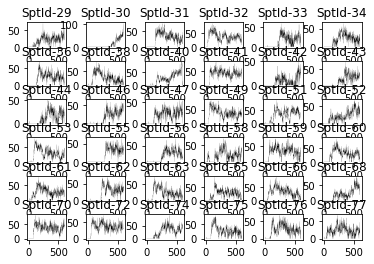

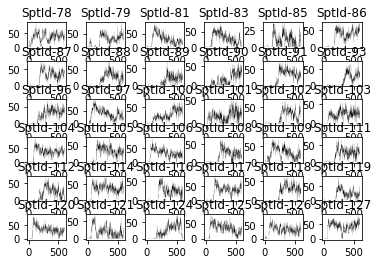

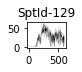

In [2]:
drosoSNAdata = readDataInFile(DataFilePath)
print(drosoSNAdata.read_data(0))

In [ ]:
# Define the parameters

# ---------------- Save these parameters -----------------#
parameterFile = 'drosoParameters'
params = setParameters(parameterFile)

#import function to perform deconvolution
from deconvolveMyData import *

#----------------- Run deconvolution----------------------#
numberOfWorkers = 5
DataFilePathToPreProcessedFile = './sna/npzdatafiles/'
fileFormatData = '.npz'
deconvolveMyData(DataFilePath = DataFilePathToPreProcessedFile, 
                 number_of_workers=numberOfWorkers)

In [ ]:

#----------------- Fit 2 state model-----------------------#

pathToDeconvolutionResultsFolder='./sna/npzdatafiles/resultDec/'
pardor='drosoParameters.npz'
Fit2Results=fit2(pathToDeconvolutionResultsFolder,pardor)

#----------------- Fit 3 state model-----------------------#

pathToDeconvolutionResultsFolder='./sna/npzdatafiles/resultDec/'
pardor='drosoParameters.npz'
Fit3Results=fit3(pathToDeconvolutionResultsFolder,pardor)